# **# 1. Image Classification Rock Paper Scissor Menggunakan Convolutional Neural Network(CNN)**

**1.1KÜTÜPHANELERİ İÇE AKTARIR**

# Kütüphane Açıklamaları

- **keras.preprocessing.image:** Görüntü verilerini işlemek ve önceden işlemek için, özellikle de veri artırma için kullanılır.

- **keras.preprocessing:** Keras'ın ön işleme modülleri.

- **tensorflow:** Açık kaynaklı makine öğrenimi kütüphanesi.

- **matplotlib.pyplot:** Görselleştirmeler yapmak için kullanılır.

- **matplotlib.image:** Görüntü dosyalarını okumak ve işlemek için.

- **pandas:** Veri analizi ve manipülasyonu için kullanılan kütüphane.

- **numpy:** Bilimsel hesaplama için çok boyutlu diziler ve matematiksel işlemler sağlar.

- **os:** İşletim sistemiyle etkileşim kurmak için, dosya ve dizin işlemleri için.

- **tensorflow.keras.optimizers.RMSprop:** Keras'ın RMSprop optimizer'ı, modelin ağırlıklarını güncellemek için kullanılır.

- **%matplotlib inline:** Jupyter Notebook'ta matplotlib grafiklerini direkt olarak görüntülemek için kullanılan bir "magic command".
`


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os 
from tensorflow.keras.optimizers import RMSprop
%matplotlib inline

# # **1.2 Load Dataset**

**1.2.1 Directory Management**

# Veri Dizinleri

- **build_dir ('rps-cv-images'):** Ana dizin, projenin temel dizinidir.

  - **rock_dir:** 'rock' sınıfına ait görüntülerin bulunduğu dizin.

  - **paper_dir:** 'paper' sınıfına ait görüntülerin bulunduğu dizin.

  - **scissors_dir:** 'scissors' sınıfına ait görüntülerin bulunduğu dizin.

Dizin İçeriği:

- `os.listdir(build_dir)` kullanılarak `build_dir` dizini içindeki dosyalar ve alt dizinler listelenir.


In [2]:
build_dir = 'rps-cv-images'
rock_dir = os.path.join(build_dir,'rock')
paper_dir = os.path.join(build_dir,'paper')
scissors_dir = os.path.join(build_dir,'scissors')
os.listdir(build_dir)

['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']

### Toplam görüntü sayılarına göre veri çerçevesi oluşturur

In [3]:
pd.DataFrame(data=[len(os.listdir(rock_dir)), len(os.listdir(paper_dir)), len(os.listdir(scissors_dir))], index=['Rock Image', 'Paper Image', 'Scissor Image'], columns=['Total Image'])

,Total Image
Rock Image,726
Paper Image,712
Scissor Image,750


**1.2.2 Image Processing(Data Augmentation)**

# Eğitim veri setine ait özellikler tanımlanmıştır

In [4]:
generator = ImageDataGenerator(
    rescale = 1/255.0,
    zoom_range = 0.25,
    rotation_range = 10,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',      #Boş pixelleri en yakın komşu pixsellerle doldurur
    validation_split = 0.4      #%40'ı doğrulama alt kümesine ayırır
)
train_generator = generator.flow_from_directory(
    build_dir,                  #Görüntülerin bulunduğu dizini ifade eder
    target_size = (250,250),
    batch_size = 32,
    class_mode = 'categorical', #Çoklu sınıf sınıflandırma problemleri için kategorik etiketlendirme yapar
    color_mode = 'rgb',
    subset = 'training'
)
val_generator = generator.flow_from_directory(
    build_dir,
    target_size = (250,250),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'validation'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


# # **2. Build CNN**

In [5]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(250, 250, 3)),#İlk konvolüsyon katmanı. 32 adet 3x3 filtre kullanılır. 
        #                                                                                Aktivasyon fonksiyonu olarak ReLU kullanılır. 
        #                                                                      Giriş şekli 150x150 piksel boyutunda ve 3 renk kanalına sahip bir görüntüdür.
        tf.keras.layers.MaxPooling2D(2, 2),#2x2 boyutunda bir maksimum havuzlama işlemi uygular, bu da görüntü boyutunu yarıya indirir.
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),#Tam bağlantılı (fully connected) katmanlara geçiş için düzleştirme işlemi.Tek boyutlu vektöre ekler
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),#Dropout katmanı, aşırı uyuma karşı koruma sağlamak için, ancak bu sefer %50 oranında nöronları devre dışı bırakır.
        tf.keras.layers.Dense(3, activation=tf.nn.softmax)#Çıkış katmanı.3 nörona sahiptir. Aktivasyon fonksiyonu:softmax(sınıflar arasında olasılıkları normalleştirir.)
])

#### Bir Keras fonksiyonudur. Bu fonksiyon,önemli bilgileri özetleyerek kullanıcıya tablo şeklinde sunar. Bu tablo, modelin katmanlarını, her katmanın çıkış şeklini (Output Shape), her katmandaki parametre sayısını (Param #) ve toplam parametre sayısını gösterir. 


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 124, 124, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

Callback'ler, eğitim sırasında model üzerinde belirli olayları ele almak ve özelleştirmek için kullanılır.Her epoch'un sonunda çağrılacak on_epoch_end fonksiyonunu içerir.

on_epoch_end fonksiyonu, her epoch'un sonunda çağrılır ve belirli bir doğruluk değerini kontrol eder.Belirli bir doğruluk seviyesine ulaştığında eğitimin otomatik olarak durmasını sağlar.

In [7]:
class CallbackAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.97):
            print("\nReached %2.2f%% accuracy, training has been stop" %(logs.get('accuracy')*100))
            self.model.stop_training = True
callbacks = CallbackAcc()

Modelin eğitim öncesi ayarlarını belirlemek ve eğitim sürecini başlatmak için gerekli olan bazı parametreleri belirtmek amacıyla gerçekleştirilir.

In [8]:
model.compile(loss='categorical_crossentropy',#Eğitim sırasında kullanacağı kayıp fonksiyonu belirtir
              optimizer=RMSprop(),#Eğitim sırasında kullanacağı optimize edici algoritma
              metrics=['accuracy'])#Modelin doğru sınıflandırma oranını ölçer

## Eğitimi başlatmak için kullanılır

In [10]:
historyModel = model.fit(
    train_generator,#Modelin eğitim verilerini oluşturmak ve öğrenmek için kullanacağı veri setini sağlar
    steps_per_epoch = 40,#25,35 Bu parametre, bir epoch boyunca kaç tane batch işleme yapılacağını belirler
    epochs = 40,#20,35 Toplam eğitim epoch sayısını belirtir. Bir epoch, modelin tüm eğitim veri setini bir kere geçmesidir
    validation_data = val_generator,#Doğrulama için kullanılacak veri setini belirtir.
    validation_steps = 5,#Her bir doğrulama epoch'u için kaç adımın tamamlanacağını belirtir.
    verbose = 2,#Eğitim sırasında gösterilecek çıktı düzeyini belirtir.
    callbacks = [callbacks])#Model eğitim sırasında kullanılacak callback fonksiyonlarını belirtir.Callbacks modelin ağırlıklarını kaydeder

Epoch 1/40
40/40 - 34s - loss: 0.3932 - accuracy: 0.8480 - val_loss: 0.3302 - val_accuracy: 0.9062 - 34s/epoch - 847ms/step
Epoch 2/40
40/40 - 30s - loss: 0.3471 - accuracy: 0.8808 - val_loss: 0.3607 - val_accuracy: 0.8625 - 30s/epoch - 758ms/step
Epoch 3/40
40/40 - 30s - loss: 0.3428 - accuracy: 0.8872 - val_loss: 0.2396 - val_accuracy: 0.9312 - 30s/epoch - 753ms/step
Epoch 4/40
40/40 - 31s - loss: 0.2955 - accuracy: 0.8944 - val_loss: 0.2969 - val_accuracy: 0.9312 - 31s/epoch - 772ms/step
Epoch 5/40
40/40 - 33s - loss: 0.2703 - accuracy: 0.9064 - val_loss: 0.3037 - val_accuracy: 0.9375 - 33s/epoch - 822ms/step
Epoch 6/40
40/40 - 30s - loss: 0.2384 - accuracy: 0.9234 - val_loss: 0.4777 - val_accuracy: 0.8000 - 30s/epoch - 747ms/step
Epoch 7/40
40/40 - 31s - loss: 0.2298 - accuracy: 0.9232 - val_loss: 0.2632 - val_accuracy: 0.9375 - 31s/epoch - 764ms/step
Epoch 8/40
40/40 - 29s - loss: 0.2160 - accuracy: 0.9280 - val_loss: 0.2745 - val_accuracy: 0.9187 - 29s/epoch - 722ms/step
Epoch 9/

1/1 [==============================] - 0s 82ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Tas yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Tas yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Tas yapti
1/1 [==============================] - 0s 22ms/step
Oyuncu Tas yapti
1/1 [==============================] - 0s 20ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 20ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 22ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 20ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 21ms/step
Oyuncu Kagit yapti
1/1 [==============================] - 0s 20ms/step
Oyuncu Makas yapti


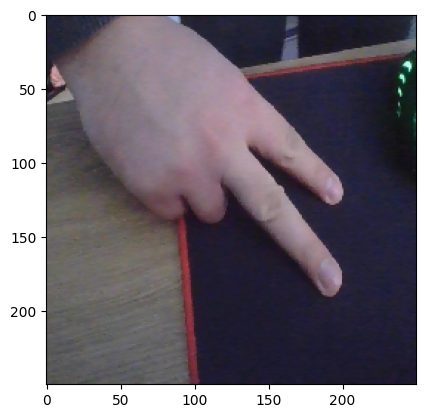

In [ ]:
import cv2





























import cv2
import cvzone
from cvzone.HandTrackingModule import HandDetector
import time
import random


cap = cv2.VideoCapture(0)
cap.set(3,640)
cap.set(4,480)


classes=0
timer = 0

stateResult = False
startGame = False
scores = [0,0] #[AI, Plyer]




while True:
    imgBG = cv2.imread("Resources\BG.png")
    success, img = cap.read()

    imgScaled = cv2.resize(img,(0,0),None,0.875,0.875)
    imgScaled = imgScaled[:,80:480]


    # El bulma
    

    if startGame:

        if stateResult is False:
            timer = time.time() - initialTime
            cv2.putText(imgBG,str(int(timer)),(605,435),cv2.FONT_HERSHEY_PLAIN, 6, (255 , 0, 255),4)

            if timer>3:
                stateResult = True
                timer = 0

                playerMove = 0

                
                if classes[0, 0] == 1:
                    playerMove=1#Kagit
                elif classes[0, 1] == 1:
                    playerMove=2#Tas
                else:
                    playerMove=3#Makas


                
                randomNumber = random.randint(1,3)
                imgAI = cv2.imread(f'Resources/{randomNumber}.png',cv2.IMREAD_UNCHANGED)
                
                imgBG = cvzone.overlayPNG(imgBG,imgAI,(149,310))
                
                #Player Wins
                if(playerMove == 1 and randomNumber == 3) or (playerMove == 2 and randomNumber == 1) or (playerMove == 3 and randomNumber == 2):
                    scores[1] +=1

                #AI Wins
                if(playerMove == 3 and randomNumber == 1) or (playerMove == 1 and randomNumber == 2) or (playerMove == 2 and randomNumber == 3):
                    scores[0] +=1

                if playerMove==1:
                    print('Oyuncu Tas yapti')
                if playerMove==2:
                    print('Oyuncu Kagit yapti')
                if playerMove==3:
                    print('Oyuncu Makas yapti')







    imgBG[234:654,795:1195] = imgScaled #ekrana görüntüyü yerleştirme

    if stateResult:
        imgBG = cvzone.overlayPNG(imgBG,imgAI,(149,310))

    cv2.putText(imgBG,str(scores[0]),(410,215),cv2.FONT_HERSHEY_PLAIN, 4, (255 , 255, 255),6)
    cv2.putText(imgBG,str(scores[1]),(1112,215),cv2.FONT_HERSHEY_PLAIN, 4, (255 , 255, 255),6)




    cv2.imshow("BG", imgBG)


    key = cv2.waitKey(1)
    if key == ord('s'):
        
        initialTime = time.time()
        stateResult = False
        ret, frame = cap.read()
        cv2.imwrite('canli_kamera_fotograf.jpg', frame)
        uploaded = "canli_kamera_fotograf.jpg"

        
        
        #uploaded= os.path.join(scissors_dir,'1MMkSW3f1CAsw03q.png')#Makas

        #uploaded= os.path.join(paper_dir,'0Uomd0HvOB33m47I.png')#Kagıt

        #uploaded= os.path.join(rock_dir,'1BqjHe5igJAgUjiN.png')#Tas





        img = image.load_img(uploaded, target_size = (250, 250))        
        imgplot = plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)#Numpy dizisi boyutu genişletilir. Modelin beklentisine uyacak şekilde boyut eklenir.
        images = np.vstack([x])
        classes = model.predict(images, batch_size = 10)#Çekindiğimiz fotoğrafı sınıflandırma algoritması olan CNN ile sınıflandırarak bize bir tahmin oluşturur.
        startGame = True
    
    # 'q' tuşuna basılırsa döngüyü kır
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()#Kamerayı serbest bırakır. Kameraya erişim sona erer.
        cv2.destroyAllWindows()#Açık olan tüm penceleri kapatır ve pencereleri temizler.
        break







# BurdaN SONRASI AYARSIZ

In [ ]:


import time
kamera = cv2.VideoCapture(0) #Bilgisayarımızın kamerasına erişir

while True:
    ret, frame = kamera.read()#Kamera görüntüsü alınır ve ret değişkeni, çerçevenin doğru bir şekilde alınıp alınmadığını belirtir.
                              # Frame değişkeni, alınan görüntüyü temsil eder.
    
    cv2.imshow('Canlı Kamera', frame)#Alınan kamera görüntüsü, "Canlı Kamera" başlığı altında bir pencerede gösterilir.

    # 'q' tuşuna basılırsa döngüyü kır
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('canli_kamera_fotograf.jpg', frame)
        print("Fotoğraf kaydedildi.")
        
        break

    # # 's' tuşuna basılırsa kareyi kaydet
    # elif cv2.waitKey(1) & 0xFF == ord('s'):
    #     cv2.imwrite('canli_kamera_fotograf.jpg', frame)
    #     print("Fotoğraf kaydedildi.")

kamera.release()#Kamerayı serbest bırakır. Kameraya erişim sona erer.
cv2.destroyAllWindows()#Açık olan tüm penceleri kapatır ve pencereleri temizler.



In [ ]:
kamera = cv2.VideoCapture(0) #Bilgisayarımızın kamerasına erişir

while True:
    ret, frame = kamera.read()#Kamera görüntüsü alınır ve ret değişkeni, çerçevenin doğru bir şekilde alınıp alınmadığını belirtir.
                              # Frame değişkeni, alınan görüntüyü temsil eder.
    
    cv2.imshow('Canlı Kamera', frame)#Alınan kamera görüntüsü, "Canlı Kamera" başlığı altında bir pencerede gösterilir.

    # 'q' tuşuna basılırsa döngüyü kır
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('canli_kamera_fotograf.jpg', frame)
        print("Fotoğraf kaydedildi.")
        
        break

    # # 's' tuşuna basılırsa kareyi kaydet
    # elif cv2.waitKey(1) & 0xFF == ord('s'):
    #     cv2.imwrite('canli_kamera_fotograf.jpg', frame)
    #     print("Fotoğraf kaydedildi.")

kamera.release()#Kamerayı serbest bırakır. Kameraya erişim sona erer.
cv2.destroyAllWindows()#Açık olan tüm penceleri kapatır ve pencereleri temizler.



Fotoğraf kaydedildi.


1/1 [==============================] - 0s 21ms/step
[[1. 0. 0.]]
Kagıt


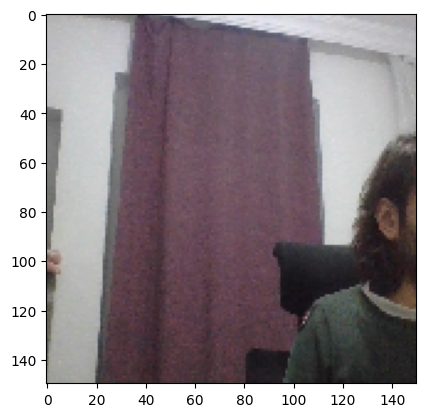

In [ ]:
#uploaded= os.path.join(scissors_dir,'1MMkSW3f1CAsw03q.png')#Makas

#uploaded= os.path.join(paper_dir,'0Uomd0HvOB33m47I.png')#Kagıt

#uploaded= os.path.join(rock_dir,'1BqjHe5igJAgUjiN.png')#Tas


uploaded = "canli_kamera_fotograf.jpg"
img = image.load_img(uploaded, target_size = (150, 150))

imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)#Numpy dizisi boyutu genişletilir. Modelin beklentisine uyacak şekilde boyut eklenir.
images = np.vstack([x])

classes = model.predict(images, batch_size = 10)#Çekindiğimiz fotoğrafı sınıflandırma algoritması olan CNN ile sınıflandırarak bize bir tahmin oluşturur.
print(classes)

#Tahminin hangisine ait olduğunu belirtir
if classes[0, 0] == 1:
    print('Kagıt')
elif classes[0, 1] == 1:
    print('Tas')
else:
    print('Makas')








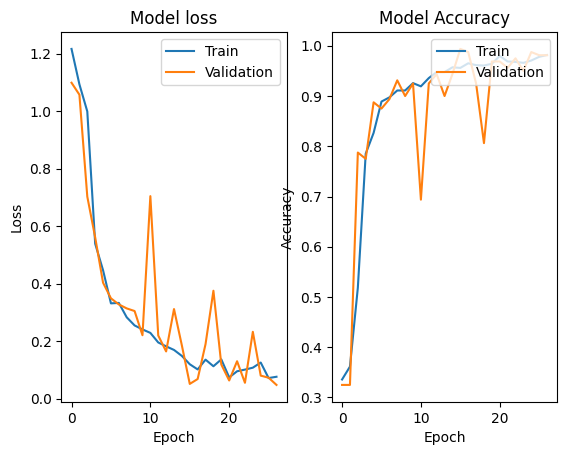

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(historyModel.history['loss'])
plt.plot(historyModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(historyModel.history['accuracy'])
plt.plot(historyModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



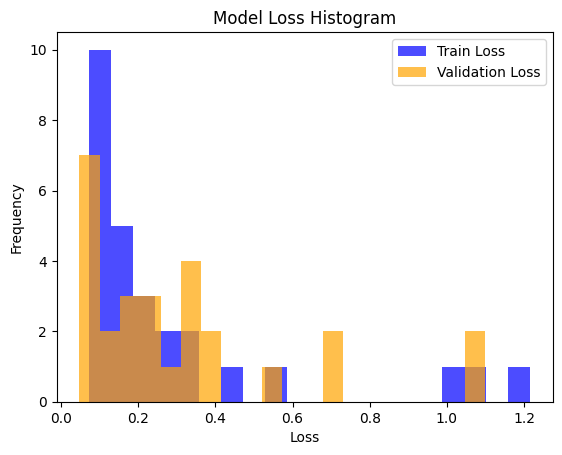

In [ ]:

plt.hist(historyModel.history['loss'], bins=20, color='blue', alpha=0.7, label='Train Loss')
plt.hist(historyModel.history['val_loss'], bins=20, color='orange', alpha=0.7, label='Validation Loss')
plt.title('Model Loss Histogram')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

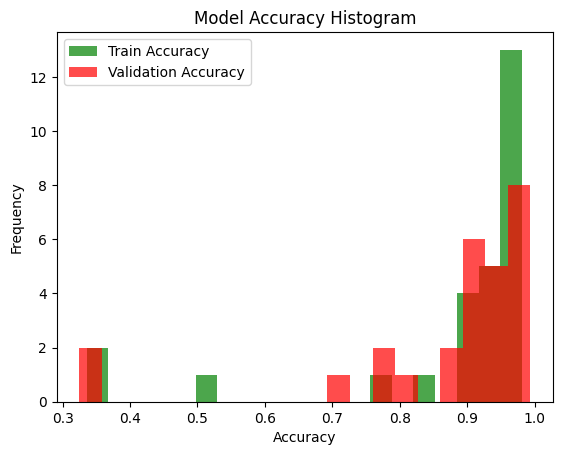

In [ ]:


plt.hist(historyModel.history['accuracy'], bins=20, color='green', alpha=0.7, label='Train Accuracy')
plt.hist(historyModel.history['val_accuracy'], bins=20, color='red', alpha=0.7, label='Validation Accuracy')
plt.title('Model Accuracy Histogram')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
rock_dir = "rock"
scissors_dir = "scissors"
paper_dir = "paper"

# Her sınıfa ait resim sayıları
rock_count = len(os.listdir(rock_dir))
scissors_count = len(os.listdir(scissors_dir))
paper_count = len(os.listdir(paper_dir))

# Kategori isimleri
categories = ['Rock', 'Scissors', 'Paper']

# Her bir kategoriye ait resim sayılarını içeren diziyi oluşturur
image_counts = [rock_count, scissors_count, paper_count]


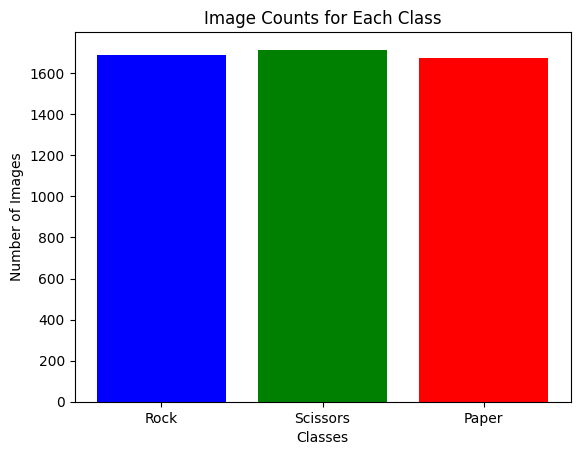

In [ ]:

# Bar Grafiği

plt.bar(categories, image_counts, color=['blue', 'green', 'red'])
plt.title('Image Counts for Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


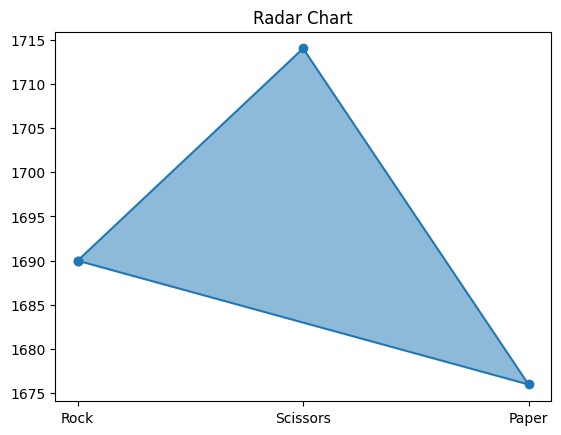

In [ ]:

# Radar Chart

plt.plot(categories + [categories[0]], image_counts + [image_counts[0]], linestyle='solid', marker='o')
plt.fill(categories + [categories[0]], image_counts + [image_counts[0]], alpha=0.5)#Çizginin çevresini dolduran bir alan oluşturur. alpha=0.2 ile doldurulan alanın şeffaflığını belirler.
plt.title('Radar Chart')

plt.show()
